# <center>Master M2 MVA 2017/2018 - Graphical models - HWK 3<center/>
### <center>WANG Yifan && CHU Xiao<center/>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal as norm
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Data loading
data_path = 'classification_data_HWK3/'
train = np.loadtxt(data_path + 'EMGaussian.data')
test = np.loadtxt(data_path + 'EMGaussian.test')
print(train.shape, test.shape)

(500, 2) (500, 2)


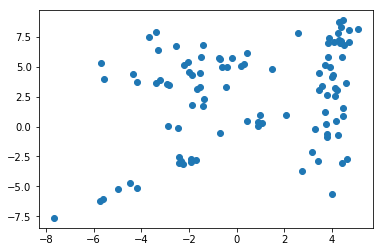

In [23]:
plt.scatter(train[0:100,0], train[0:100,1])
plt.show()

## Question 1
The code is implemented in class `HMM`, in function `gamma_` ( for $p(q_t |u_1 ,... , u_T )$) and `ksi_` ( for $p(q_t , q_{t+1} |u_1 ,..., u_T )$).

In [24]:
class HMM(object):
    def __init__(self, K, A, means, covs, pi):
        """
        Args:
            K (int): number of states
            A: transition matrix A(u, q) = p(u|q)
            pi (K,1): prior p(q)
            means: means of guassian distributions
            covs: covariances of gaussian distributions
        """
        self.K = K
        self.A = A
        self.pi = pi
        self.means = means
        self.covs = covs
        
    def p_(self, z, u):
        """ Gaussian emission probability ~ N(means, covs)
        Args: 
            z: latent variable, 0...K-1
            u: observation
        """
        return norm.pdf(u, self.means[z], self.covs[z])
        
    def emission_(self, u):
        """ Compute p(u|q=0...K-1)
            u: observation
            q: latent variable
        Return:
            proba (K, 1)
        """
        eps = 1e-30
        proba = np.asarray([self.p_(z, u) for z in range(self.K)]).reshape(-1,1) + eps
        return proba
        
    def alpha(self, data):
        """ p(u_1...u_t, q_t)
        Return:
            alpha (K, T)
            logalpha (K, T)
        """
        T = len(data)
        eps = 1e-30
        logalpha = np.zeros((self.K, T))
        logalpha[:, 0] = (np.log(self.emission_(data[0]) + eps) + np.log(self.pi) + eps).reshape(-1)
        for t in range(1, T):
            logalpha_max = logalpha[:, t-1].max()
            p = np.exp(logalpha[:, t-1] - logalpha_max).reshape(-1,1)
            logalpha[:, t] = (np.log(self.emission_(data[t]) + eps) \
                                    + np.log(self.A.dot(p) + eps) + logalpha_max).reshape(-1)
        alpha = np.exp(logalpha)
        return alpha, logalpha
        
    
    def beta(self, data):
        """ p(u_{t+1}...u_T|q_t)
        Return:
            beta (K, T)
            logbeta (K, T)
        """
        T = len(data)
        eps = 1e-30
        logbeta = np.zeros((self.K, T))
        logbeta[:, T-1] = (np.log(self.emission_(data[0]) + eps) + np.log(self.pi + eps)).reshape(-1)
        for t in range(1, T):
            t = T - t -1 # T-2 ... 0
            logbeta_max = logbeta[:, t+1].max()
            p = np.exp((logbeta[:, t+1] - logbeta_max).reshape(-1,1) + np.log(self.emission_(data[t+1]) + eps)).reshape(-1,1)
            logbeta[:, t] = (np.log(self.A.T.dot(p) + eps) + logbeta_max).reshape(-1)
        beta = np.exp(logbeta)
        return beta, logbeta
        
    def gamma_(self, data):
        """ Marginal posterior distribution of all latent variable q_t=0..T-1: p(q_t|U) 
        Return: 
            gamma (K, T)
        """
        T = len(data)
        _, logalpha = self.alpha(data)
        _, logbeta = self.beta(data)
        gamma = np.zeros((self.K, T))
        for t in range(T):
            log_alpha_beta = logalpha[:,t] + logbeta[:,t]
            log_alpha_beta_max = np.max(log_alpha_beta)
            # p(q_t, U)
            p = np.exp(log_alpha_beta-log_alpha_beta_max)
            gamma[:, t] = p/np.sum(p)
        return gamma
    
    def ksi_(self, data):
        """ Joint posterior distribution of two successive latent variables: ksi[i,j] = p(q_t=i, q_t+1=j|U) 
        Return: 
            ksi (K, K, T-1)
        """
        T = len(data)
        _, logalpha = self.alpha(data)
        _, logbeta = self.beta(data)
        ksi = np.zeros((self.K, self.K, T-1))
        log_ksi = np.zeros((self.K, self.K, T-1))
        for t in range(T-1):
            for i in range(self.K):
                for j in range(self.K):
                    log_alpha_beta = logalpha[:, t] + logbeta[:, t]
                    log_alpha_beta_max = log_alpha_beta.max()
                    log_p = log_alpha_beta_max + np.log(np.sum(np.exp(log_alpha_beta - log_alpha_beta_max)))
                    log_ksi[i, j, t] = -log_p + logalpha[i, t] + logbeta[j, t+1] + np.log(self.A[j, i]) \
                            + np.log(self.p_(j, data[t+1]))
                    ksi[i, j, t] = np.exp(log_ksi[i, j, t])
        return ksi, log_ksi
    
    def smoothing(self, data):
        """ p(q_t|U) 
        Return: 
            gamma (K, T)
        """
        return self.gamma_(data)
    

    def lower_bound(self, data):
        """Compute lower bound of complete log likelihood
        """
        ll = 0
        eps = 1e-30
        T = len(data)
        gamma = self.gamma_(data)
        ksi, _ = self.ksi_(data)
        
        ll += np.sum(gamma[:,0].reshape(-1,1) * np.log(self.pi + eps))
        for t in range(T-1):
            ll += np.sum(ksi[:,:,t].reshape(self.K, self.K).T * np.log(self.A + eps))
        for t in range(1, T):
            ll += np.sum(gamma[:,t].reshape(-1,1) * np.log(self.emission_(data[t]) + eps))
        return ll
    
    def log_likelihood(self, data):
        """ Compute the log likelihood of the observations
        """
        T = len(data)
        _, logalpha = self.alpha(data)
        _, logbeta = self.beta(data)
        mx = (logalpha[:,0] + logbeta[:,0]).max()
        ll = np.log(np.sum([np.exp(logalpha[:,0] + logbeta[:,0] - mx) for i in range(self.K)])) + mx
        return ll
        
        
    def train(self, data, max_iter=100, verbal=True, validation=None):
        """
        Args:
            data: (T, D), training data, D is the feature dimension
            max_iter: int, maximal number of iterations
            verbal: boolean, if True, print log likelyhood
            valdation: None or (T, D), if provided, its log likelyhood will be computed and returned
        Return:
            lls: list, log likelyhoods of training data
            lls_valid: list, log likelyhoods of validation dataset
        """
        i = 0
        eps = 1e-4
        lls = [self.log_likelihood(data)]
        lls_valid = [] if validation is None else [self.log_likelihood(validation)]
        if verbal:
            print("\tTrain log likelihood: {1}".format(i, lls[0]))
            if validation is not None:
                print("\tValid log likelihood: {0}".format(lls_valid[0]))
        while i < max_iter:
            i += 1
            self.train_step(data)
            ll = self.log_likelihood(data)
            if len(lls) > 2 and (ll - lls[-1]) < eps:
                break
            lls.append(ll)
            if verbal:
                print("Iteration {0}:\n\tTrain log likelihood: {1}".format(i, ll))
            if validation is not None:
                ll_valid = self.log_likelihood(validation)
                lls_valid.append(ll_valid)
                if verbal:
                    print("\tValid log likelihood: {0}".format(ll_valid))
        return lls, lls_valid
            
            
    def train_step(self, data):
        """ Perform EM algorithm for one step
        Args:
            data: (T, D), training data, D is the feature dimension
        """
        T = len(data)
        # E-step
        gamma = self.gamma_(data)
        ksi, _ = self.ksi_(data)
        # M-step
        self.pi = (gamma[:,0] / gamma[:,0].sum()).reshape(-1,1)
        for j in range(self.K):
            for k in range(self.K):
                self.A[k, j] = ksi[j, k, :].sum()/np.sum(ksi[j, :, :])
        for k in range(self.K):
            self.means[k] = gamma[k,:].dot(data)/gamma[k,:].sum() # (1,T)*(T,D) -> (1,D)
            self.covs[k] = np.sum([gamma[k,n]*(data[n]-self.means[k]).reshape(-1, 1).dot((data[n]-self.means[k]).reshape(1,-1)) for n in range(T)], 0)/gamma[k,:].sum()
        
        
    def decode(self, data):
        """ Viterbi algorithm (forward)
        Args:
            data: (T, D), training data, D is the feature dimension
        """
        # Initialization
        T = len(data)
        eps = 1e-30
        maxProb = np.zeros((self.K, T))
        prev_state = np.zeros((self.K, T))
        # Find the index which can maximiser the tmp_proba
        for t in range(T):
            if (t==0):
                maxProb[:,0] = np.log(self.pi).reshape(-1)
            else:
                for i in range(self.K):
                    tmp_proba = maxProb[:,t-1] + np.log(A[i,:].T + eps) + np.log(self.emission_(data[t-1]) + eps).reshape(-1)
                    maxValue = np.max(tmp_proba)
                    maxIndex = np.argmax(tmp_proba)
                    maxProb[i,t] = maxValue
                    prev_state[i,t] = maxIndex                    

        tmp_proba = np.log(maxProb[:,T-1]) + np.log(self.emission_(data[T-1]) + eps).reshape(-1)
        maxValue = np.max(tmp_proba)
        maxIndex = np.argmax(tmp_proba)
        # Find the best path
        state_index_path = np.zeros(T, dtype=int)
        state_index_path[T-1] = maxIndex;
        for t in range(T-2,-1,-1):
            state_index_path[t] = prev_state[state_index_path[t+1],t+1]
            
#         # Viterbi algorithm (backward)
#         T = len(data)
#         log_viterbi = np.zeros((self.K, T))
#         log_post_viterbi = np.zeros((self.K, T))
#         viterbi_path = np.zeros((self.K, T), dtype=int)
#         for t in range(T-1,-1,-1):
#             if t == T-1:
#                 log_post_viterbi[:, t] = np.zeros(self.K)
#             else:
#                 mxvalue = np.max(log_viterbi[:, t + 1])
#                 p = np.exp(log_viterbi[:, t + 1] - mxvalue)
#                 max_x = [np.max(A.T[i, :] * p) for i in range(self.K)]
#                 viterbi_path[:, t] = [np.argmax(self.A.T[i, :] * p) for i in range(self.K)]
#                 log_post_viterbi[:, t] = np.log(max_x) + mxvalue
#             log_viterbi[:, t] = log_post_viterbi[:, t] + np.log(self.emission_(data[t])).reshape(-1)

#         state_index_path = np.ones(T, dtype=int) * -1
#         z = np.argmax(log_viterbi[:, 0])
#         state_index_path[0] = z
#         for t in range(T - 1):
#             z = viterbi_path[z, t]
#             state_index_path[t+1] = z
#         return state_index_path
        return state_index_path


In [25]:
# GMM classifier

class GMM(object):
    def __init__(self, k, covariance_type='full'):
        self.k = k
        self.mus = None
        self.alpha2 = None
        self.sigmas = None
        self.resp = None
        self.pis = None
        self.clusters = {}
        self.labels = None
        self.label_history = []
        self.covariance_type = covariance_type
        
    def train(self, X, init="kmeans"):
        n, d = X.shape
        centers = None
        # initialize
        if init == "kmeans":
            clf = KMeans(self.k)
            clf.train(X)
            self.mus = clf.centers
            self.labels = clf.labels
            self.pis = np.array([len(clf.clusters[i])/n for i in range(self.k)])
            if self.covariance_type == 'spherical':
                self.alpha2 = np.array([np.sum((np.array(clf.clusters[i]) - self.mus[i]) ** 2)/len(clf.clusters[i])/2. for i in range(self.k)])
                self.sigmas = np.array([self.alpha2[i] * np.eye(d) for i in range(self.k)])
            elif self.covariance_type == 'full':
                self.sigmas = np.array([np.cov(np.array(clf.clusters[k]).T) for k in range(self.k)])
            self.resp = np.zeros((self.k, n))
            for i in range(self.k):
                self.resp[i] = np.array(gamma(X, i, self.k, self.pis, self.mus, self.sigmas))                

        t = 0
        resp = self.resp.copy()
        pis = self.pis.copy()
        mus = self.mus.copy()
        if self.covariance_type == 'spherical':
            alpha2 = self.alpha2.copy()
        sigmas = self.sigmas.copy()
        while t < 30:
            t += 1
            # update
            for i in range(self.k):
                pis[i] = np.mean(self.resp[i])
                mus[i] = np.sum(X * self.resp[i][:, np.newaxis], 0)/np.sum(self.resp[i])
                if self.covariance_type == 'spherical':
                    alpha2[i] = np.sum([(X[j] - self.mus[i]) ** 2 * self.resp[i,j] for j in range(n)])/np.sum(self.resp[i])/2.
                    sigmas[i] = alpha2[i] * np.eye(d)
                elif self.covariance_type == 'full':
                    sigmas[i] = np.sum([(X[j] - self.mus[i]).reshape(-1,1).dot((X[j] - self.mus[i]).reshape(1,-1)) * self.resp[i,j] for j in range(n)], 0)/np.sum(self.resp[i])
            for i in range(self.k):
                resp[i] = np.array(gamma(X, i, self.k, pis, mus, sigmas))
            self.resp = resp.copy()
            self.pis = pis.copy()
            self.mus = mus.copy()
            if self.covariance_type == 'spherical':
                self.alpha2 = alpha2.copy()
            self.sigmas = sigmas.copy()
        labels = np.zeros(n)
        for i in range(n):
            self.labels[i] = np.argmax(self.resp[:, i])
            
    def test(self, X):
        n, d = X.shape
        resp = np.zeros((self.k, n))
        for i in range(self.k):
            resp[i] = np.array(gamma(X, i, self.k, self.pis, self.mus, self.sigmas))        
        labels = np.zeros(n)
        for i in range(n):
            labels[i] = np.argmax(resp[:, i])
        return labels.astype(np.int32), resp
        
    def log_likelihood(self, X):
        n, d = X.shape
        _, resp = self.test(X)
        return np.sum([[resp[k,i] * np.log(self.pis[k] * norm.pdf(X[i], self.mus[k], self.sigmas[k])) for k in range(self.k)] for i in range(n)])
    
    
# K-means classifier

class KMeans(object):
    def __init__(self, k):
        self.k = k
        self.centers = None
        self.clusters = {}
        self.labels = None
        self.inertia = None
        self.label_history = []
        
    def train(self, X, init="random"):
        n = X.shape[0]
        centers = None
        # initialize
        if init == "random":
            self.centers = X[np.random.choice(n, self.k, replace=False)]
        elif init == 'kmeans++':
            # TODO: implement K-means++
            pass
        
        while (centers is None or np.abs(centers - self.centers).max() > 1e-5):
            # old centers
            centers = self.centers.copy()
            
            for i in range(self.k):
                self.clusters[i] = []
            labels = []
            for x in X:
                dis = np.sum((centers - x)**2, 1)
                label = np.argmin(dis)
                self.clusters[label].append(x)
                labels.append(label)
            self.labels = np.array(labels)
            self.label_history.append(self.labels)
            
            # new centers
            for i in range(self.k):
                self.centers[i] = np.mean(np.array(self.clusters[i]), 0)  
                
def gamma(X, k, K, pis, mus, sigmas):
    """ Responsibilities
    """
    return (pis[k]* norm.pdf(X, mus[k], sigmas[k]))/(np.sum([pis[i]* norm.pdf(X, mus[i], sigmas[i]) for i in range(K)], 0))

## Question 2
Represent $p(q_t |u_1 ,..., u_T )$ for each of the 4 states as a function of time for the 100 ﬁrst data points in `EMGaussienne.test`.

In [26]:
A = np.diag([1./2 - 1./6]*4) + np.ones((4,4)) * 1./6
pi = np.ones((4,1))/4.
# pre-train GMM
clf = GMM(4, covariance_type='full')
clf.train(test)
# train HMM
hmm = HMM(K=4, A=A, pi=pi, means=clf.mus, covs=clf.sigmas)

In [27]:
smoothing = hmm.smoothing(test)
print(smoothing.shape)

(4, 500)


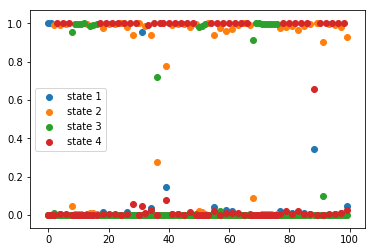

In [28]:
for i in range(4):
    plt.scatter(range(100), smoothing[i, :100])
plt.legend(['state 1', 'state 2', 'state 3', 'state 4'])
plt.show()

## Question 3
Derive the estimation equations of the EM algorithm.


## Question 4
Implement the EM algorithm to learn the parameters of the model ($\pi$, $A$, $\mu_k$ , $\Sigma_k$, $k = 1...4$). The means and covariances could be initialized with the ones obtained in the previous homework. Learn the model from the training data in“EMGaussienne.data”.


In [29]:
A = np.diag([1./2 - 1./6]*4) + np.ones((4,4)) * 1./6
pi = np.ones((4,1))/4.
clf = GMM(4, covariance_type='full')
clf.train(train)
# train HMM
hmm = HMM(K=4, A=A, pi=pi, means=clf.mus, covs=clf.sigmas)
ll, ll_valid = hmm.train(train, max_iter=20, verbal=True, validation=test)

	Train log likelihood: -2303.3517562913344
	Valid log likelihood: -2426.4932058164354
Iteration 1:
	Train log likelihood: -1914.8263003513314
	Valid log likelihood: -1978.5710222419336
Iteration 2:
	Train log likelihood: -1900.7279063146755
	Valid log likelihood: -1961.6284824594331
Iteration 3:
	Train log likelihood: -1899.10218646958
	Valid log likelihood: -1958.274752108972
Iteration 4:
	Train log likelihood: -1898.896972517673
	Valid log likelihood: -1957.1146329638389
Iteration 5:
	Train log likelihood: -1898.8675874724195
	Valid log likelihood: -1956.628536351202
Iteration 6:
	Train log likelihood: -1898.8634074916206
	Valid log likelihood: -1956.4391473903618
Iteration 7:
	Train log likelihood: -1898.862829300888
	Valid log likelihood: -1956.3681585928646


## Question 5
Plot the log-likelihood on the train data “EMGaussienne.data” and on the test data “EMGaussienne.test” as a function of the iterations of the algorithm. Comment.

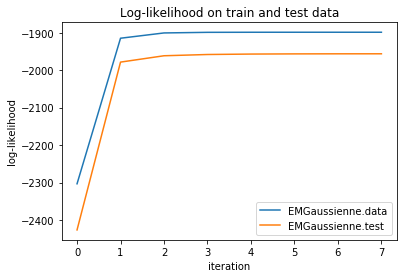

In [30]:
plt.plot(ll)
plt.plot(ll_valid)
plt.legend(['EMGaussienne.data', 'EMGaussienne.test'])
plt.title("Log-likelihood on train and test data")
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

## Question 6
Return in a table the values of the log-likelihoods of the Gaussian mixture models and of the HMM on the train and on the test data. 

In [31]:
# GMM
print("GMM-train:", clf.log_likelihood(train))
print("GMM-test:", clf.log_likelihood(test))

# HMM
print("HMM-train:", hmm.log_likelihood(train))
print("HMM-test:", hmm.log_likelihood(test))

GMM-train: -2373.00003677
GMM-test: -2453.46384428
HMM-train: -1898.86275178
HMM-test: -1956.34194126


### 8. Implement Viterbi decoding.

In [32]:
viterbi_path = hmm.decode(train)

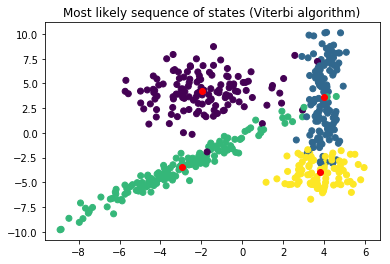

In [33]:
plt.figure()
plt.title("Most likely sequence of states (Viterbi algorithm)")
plt.scatter(train[:,0], train[:,1], c=viterbi_path)
plt.scatter(hmm.means[:,0], hmm.means[:,1], color = "red")
plt.show()

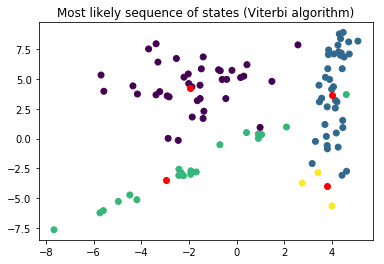

In [34]:
plt.figure()
plt.title("Most likely sequence of states (Viterbi algorithm)")
plt.scatter(train[0:100,0], train[0:100,1], c=viterbi_path[0:100])
plt.scatter(hmm.means[:,0], hmm.means[:,1], color = "red")
plt.show()

### 9. For the datapoints in the test file “EMGaussienne.test”, compute the marginal probability p(qt|u_1, . . . , u_T) for each point to be in state {1,2,3,4} for the parameters learned on the training set.

In [35]:
gamma_test = hmm.smoothing(test)

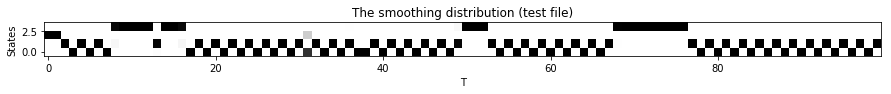

In [36]:
plt.figure(figsize=(15,5))
plt.title("The smoothing distribution (test file)")
plt.imshow(1-gamma_test[:,0:100], cmap="gray",origin="lower")
plt.xlabel("T")
plt.ylabel("States")
plt.show()

### 10. For each of these same 100 points, compute their most likely state according to the marginal probability computed in the previous question.

In [37]:
state_smoothing = np.argmax(gamma_test, axis=0)

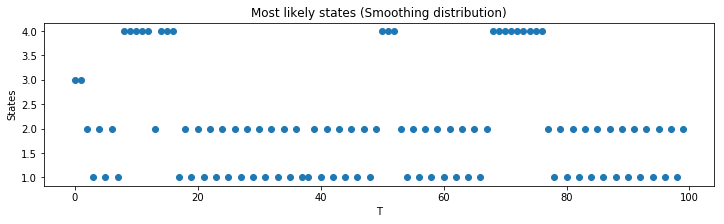

In [38]:
plt.figure(figsize=(12,3))
plt.title("Most likely states (Smoothing distribution)")
plt.scatter(np.arange(100), state_smoothing[0:100]+1)
plt.xlabel("T")
plt.ylabel("States")
plt.show()

### 11. Run Viterbi on the test data. Compare the most likely sequence of states obtained for the 100 first data points with the sequence of states obtained in the previous question.

In [39]:
viterbi_test = hmm.decode(test)

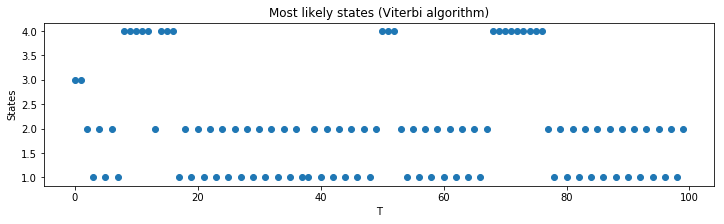

In [40]:
plt.figure(figsize=(12,3))
plt.title("Most likely states (Viterbi algorithm)")
plt.scatter(np.arange(100), viterbi_test[0:100]+1)
plt.xlabel("T")
plt.ylabel("States")
plt.show()